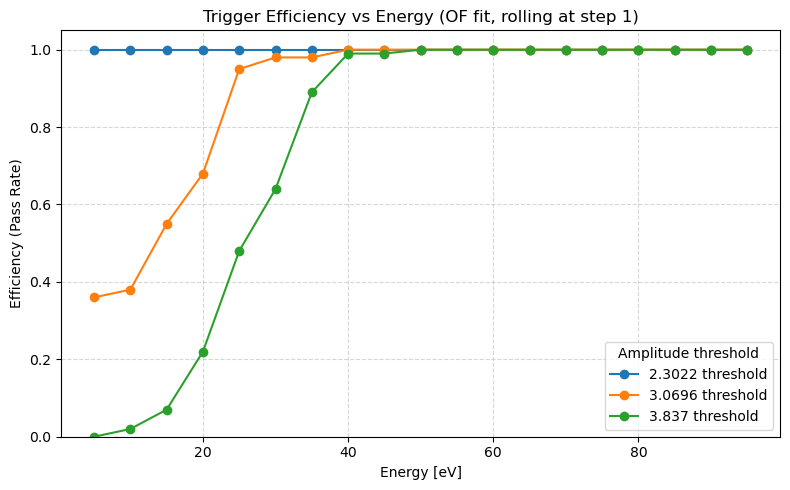

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fs = 3_906_250
sigma = 0.7674
thresholds = [round(n * sigma, 4) for n in (3, 4, 5)]
energy_values = list(range(5, 100, 5))   # 5..95
n_sets = 100

pass_rates_by_threshold = {th: [] for th in thresholds}

def per_event_max(ampl_arr: np.ndarray) -> np.ndarray:
    """
    Return the per-event maximum amplitude across channels (and time if present).
    Accepts shapes:
      (N,)                -> already per-event amplitudes
      (N, C)              -> max over channels
      (N, C, T)           -> max over time, then channels
    """
    a = np.asarray(ampl_arr)
    if a.ndim == 1:
        return a
    elif a.ndim == 2:
        return a.max(axis=1)           # max over channels
    elif a.ndim == 3:
        return a.max(axis=(2, 1))      # max over time, then channels
    else:
        raise ValueError(f"Unexpected shape {a.shape}")

for energy in energy_values:
    path = f"/ceph/dwong/trigger_samples/lts/ampl_energy_{energy}.zst"

    # This should return either (N,), (N, 9), or (N, 9, T)
    ampl_arr = load_ampl_from_zstd(path, n_traces=n_sets)

    # Per-event max across (time, channels) -> "any trace exceeds threshold" check
    per_evt_max = per_event_max(ampl_arr)
    assert per_evt_max.shape[0] == n_sets, "Mismatch in number of events"

    for th in thresholds:
        passed = per_evt_max > th            # event passes if ANY channel/time > th
        pass_rate = passed.mean()            # events passed / total events
        pass_rates_by_threshold[th].append(pass_rate)

# Plot
plt.figure(figsize=(8, 5))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th],
             marker='o', linewidth=1.5, label=f'{th:g} threshold')
plt.xlabel("Energy [eV]")
plt.ylabel("Efficiency (Pass Rate)")
plt.title("Trigger Efficiency vs Energy (OF fit, rolling at step 1)")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Amplitude threshold")
plt.tight_layout()
plt.show()


Loading noise amplitude traces (0 eV)...


Processing noise sets: 100%|██████████| 100/100 [00:00<00:00, 2241.84it/s]



Loading signal amplitude traces (0 eV)...


Processing 0 eV signal sets: 100%|██████████| 100/100 [00:00<00:00, 2240.38it/s]



Loading signal amplitude traces (5 eV)...


Processing 5 eV signal sets: 100%|██████████| 100/100 [00:00<00:00, 2231.00it/s]



Loading signal amplitude traces (10 eV)...


Processing 10 eV signal sets: 100%|██████████| 100/100 [00:00<00:00, 2199.76it/s]



Loading signal amplitude traces (15 eV)...


Processing 15 eV signal sets: 100%|██████████| 100/100 [00:00<00:00, 2226.22it/s]



Loading signal amplitude traces (20 eV)...


Processing 20 eV signal sets: 100%|██████████| 100/100 [00:00<00:00, 2217.80it/s]



Loading signal amplitude traces (25 eV)...


Processing 25 eV signal sets: 100%|██████████| 100/100 [00:00<00:00, 2221.82it/s]



Loading signal amplitude traces (30 eV)...


Processing 30 eV signal sets: 100%|██████████| 100/100 [00:00<00:00, 2207.97it/s]


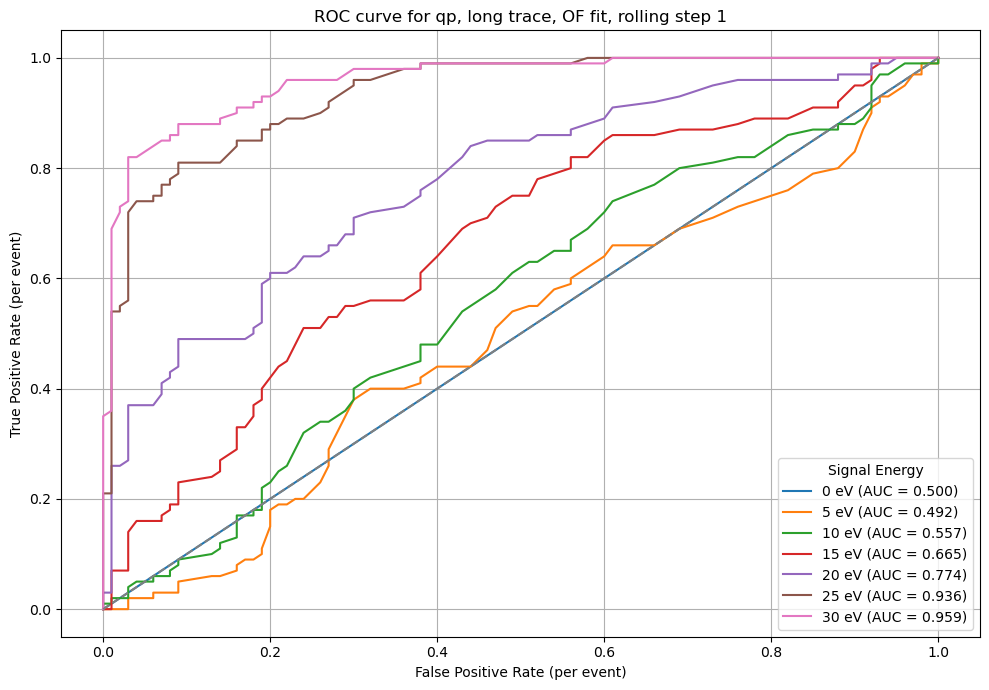

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tqdm import tqdm

# Parameters
signal_energies = [0, 5, 10, 15, 20, 25, 30]  # eV
n_noise_sets = 100
n_signal_sets = 100
traces_per_set = 9
thresholds = np.linspace(0, 6, 500)

def per_event_max(ampl_event):
    """
    ampl_event: shape (n_traces, n_samples)
    Returns: scalar max amplitude for this event
    """
    return np.max(ampl_event)  # max over both traces and time

# --- Load noise (0 eV) once ---
print("Loading noise amplitude traces (0 eV)...")
noise_traces = load_ampl_from_zstd(
    "/ceph/dwong/trigger_samples/lts/ampl_energy_0.zst",
    n_traces=n_noise_sets
)
noise_max_amplitudes = [per_event_max(event) for event in tqdm(noise_traces, desc="Processing noise sets")]
noise_max_amplitudes = np.array(noise_max_amplitudes)

# --- Plot ---
plt.figure(figsize=(10, 7))

# --- Process each signal energy ---
for signal_energy in signal_energies:
    print(f"\nLoading signal amplitude traces ({signal_energy} eV)...")
    signal_traces = load_ampl_from_zstd(
        f"/ceph/dwong/trigger_samples/lts/ampl_energy_{signal_energy}.zst",
        n_traces=n_signal_sets
    )
    signal_max_amplitudes = [per_event_max(event) for event in tqdm(signal_traces, desc=f"Processing {signal_energy} eV signal sets")]
    signal_max_amplitudes = np.array(signal_max_amplitudes)

    # Compute ROC
    tpr = []
    fpr = []
    for th in thresholds:
        tpr.append(np.mean(signal_max_amplitudes > th))
        fpr.append(np.mean(noise_max_amplitudes > th))

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{signal_energy} eV (AUC = {roc_auc:.3f})")

# Finalize plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (per event)')
plt.ylabel('True Positive Rate (per event)')
plt.title('ROC curve for qp, long trace, OF fit, rolling step 1')
plt.legend(title='Signal Energy')
plt.grid(True)
plt.tight_layout()
plt.show()


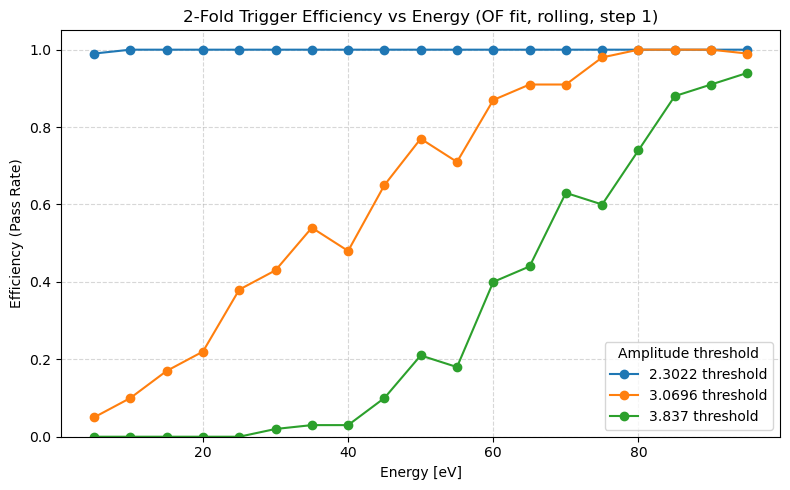

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fs = 3_906_250
sigma = 0.7674
thresholds = [round(n * sigma, 4) for n in (3, 4, 5)]
energy_values = list(range(5, 100, 5))   # 5..95
n_sets = 100

pass_rates_by_threshold = {th: [] for th in thresholds}

def per_event_kth_channel_max(ampl_arr: np.ndarray, k: int = 2) -> np.ndarray:
    """
    Return per-event k-th largest channel amplitude.
    For each event:
      - If shape is (C, T): take max over time -> (C,)
      - If shape is (C,): already per-channel amplitudes
      - Then take the k-th largest across channels.
    Accepts batches:
      (N, C, T) or (N, C) or (N,)
    """
    a = np.asarray(ampl_arr)

    if a.ndim == 3:
        # (N, C, T) -> max over time -> (N, C)
        a = np.nanmax(a, axis=2)
    elif a.ndim == 2:
        # (N, C) -> already per-channel maxima
        pass
    elif a.ndim == 1:
        # (N,) -> single-channel; fall back to k=1 behavior
        return a.copy()
    else:
        raise ValueError(f"Unexpected shape {a.shape}")

    # Replace NaNs with -inf so they don't win the max/partition
    a = np.where(np.isfinite(a), a, -np.inf)

    n_events, n_ch = a.shape
    if n_ch < k:
        # Not enough channels for k-fold; degrade gracefully to max
        return np.nanmax(a, axis=1)

    # k-th largest across channels: use np.partition for O(C)
    # After partition with -k, the last k elements are the k largest (unordered);
    # the first of those is the k-th largest.
    kth_vals = np.partition(a, -k, axis=1)[:, -k]
    return kth_vals  # shape (N,)

for energy in energy_values:
    path = f"/ceph/dwong/trigger_samples/lts/ampl_energy_{energy}.zst"

    # Expect (N, 9, T) or (N, 9) or (N,)
    ampl_arr = load_ampl_from_zstd(path, n_traces=n_sets)

    # Per-event 2-fold statistic = 2nd-largest channel max (over time)
    per_evt_k2 = per_event_kth_channel_max(ampl_arr, k=2)
    assert per_evt_k2.shape[0] == n_sets, "Mismatch in number of events"

    for th in thresholds:
        passed = per_evt_k2 > th          # event passes if 2nd-largest > threshold
        pass_rate = passed.mean()
        pass_rates_by_threshold[th].append(pass_rate)

# Plot
plt.figure(figsize=(8, 5))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th],
             marker='o', linewidth=1.5, label=f'{th:g} threshold')
plt.xlabel("Energy [eV]")
plt.ylabel("Efficiency (Pass Rate)")
plt.title("2-Fold Trigger Efficiency vs Energy (OF fit, rolling, step 1)")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Amplitude threshold")
plt.tight_layout()
plt.show()
